# Imports

In [ ]:
import pandas as pd
import sqlite3 as sql
import datetime as dt
import uuid
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 1000)

1. score metrics

ERD
game_dim
game_reports
player_dim
game_rankings (game_uuid, player_id, rank)
current_scores_view

In [120]:
games_df = pd.read_csv('game_reports3.csv', parse_dates=[2,3])
games_df['players'] = games_df['players'].apply(lambda x: x.split(" "))
games_df['player_count'] = games_df['players'].apply(lambda x: len(x))
games_df['game_length'] = games_df['game_end'] - games_df['game_start']
games_df['game_length_minutes'] = games_df['game_length'].dt.total_seconds()/60

player_games_df = games_df.explode('players')
player_games_df['place'] = player_games_df.groupby(['game_played', 'game_start'], sort=False)['players'].expanding().count().values
#t * (1+((1-p)/(2n-2))) where t = time, p = place order, and n = # of players
t = player_games_df['game_length_minutes']
p = player_games_df['place']
n = player_games_df['player_count']
player_games_df['score'] = np.round(t * (1+((1-p)/(2*n-2))))
player_games_df


C:\Users\skylar\AppData\Local\Temp\ipykernel_16940\3532920429.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  games_df = pd.read_csv('game_reports3.csv', parse_dates=[2,3])
C:\Users\skylar\AppData\Local\Temp\ipykernel_16940\3532920429.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  games_df = pd.read_csv('game_reports3.csv', parse_dates=[2,3])


,game_played,players,game_start,game_end,great,player_count,game_length,game_length_minutes,place,score
0,Sidereal_Confluence,Rachel,2024-12-09 09:37:00,2024-12-09 11:40:00,1,7,0 days 02:03:00,123.0,1.0,123.0
0,Sidereal_Confluence,Max,2024-12-09 09:37:00,2024-12-09 11:40:00,1,7,0 days 02:03:00,123.0,2.0,113.0
0,Sidereal_Confluence,Kristi,2024-12-09 09:37:00,2024-12-09 11:40:00,1,7,0 days 02:03:00,123.0,3.0,102.0
0,Sidereal_Confluence,Matt,2024-12-09 09:37:00,2024-12-09 11:40:00,1,7,0 days 02:03:00,123.0,4.0,92.0
0,Sidereal_Confluence,John,2024-12-09 09:37:00,2024-12-09 11:40:00,1,7,0 days 02:03:00,123.0,5.0,82.0
...,...,...,...,...,...,...,...,...,...,...
28,Wyrmspan2,Les,2024-12-09 18:10:00,2024-12-09 19:00:00,0,5,0 days 00:50:00,50.0,1.0,50.0
28,Wyrmspan2,Guy,2024-12-09 18:10:00,2024-12-09 19:00:00,0,5,0 days 00:50:00,50.0,2.0,44.0
28,Wyrmspan2,Ryan,2024-12-09 18:10:00,2024-12-09 19:00:00,0,5,0 days 00:50:00,50.0,3.0,38.0
28,Wyrmspan2,Gaby,2024-12-09 18:10:00,2024-12-09 19:00:00,0,5,0 days 00:50:00,50.0,4.0,31.0


In [121]:
player_games_df.groupby('players')['score'].sum()

players
Alecia      194.0
Brenna      319.0
Dane        200.0
Dani        136.0
Gaby        305.0
Guy         188.0
J           241.0
Jess         25.0
John        196.0
Judson      440.0
Jules        63.0
Karson      398.0
Kate        164.0
Kristi      420.0
Les         346.0
Libby        85.0
Mac          43.0
Matt        333.0
Max         400.0
Paul        236.0
Rachel      318.0
Ryan        247.0
Scoggins    256.0
Skylar      399.0
Toph         47.0
Zack        398.0
Name: score, dtype: float64

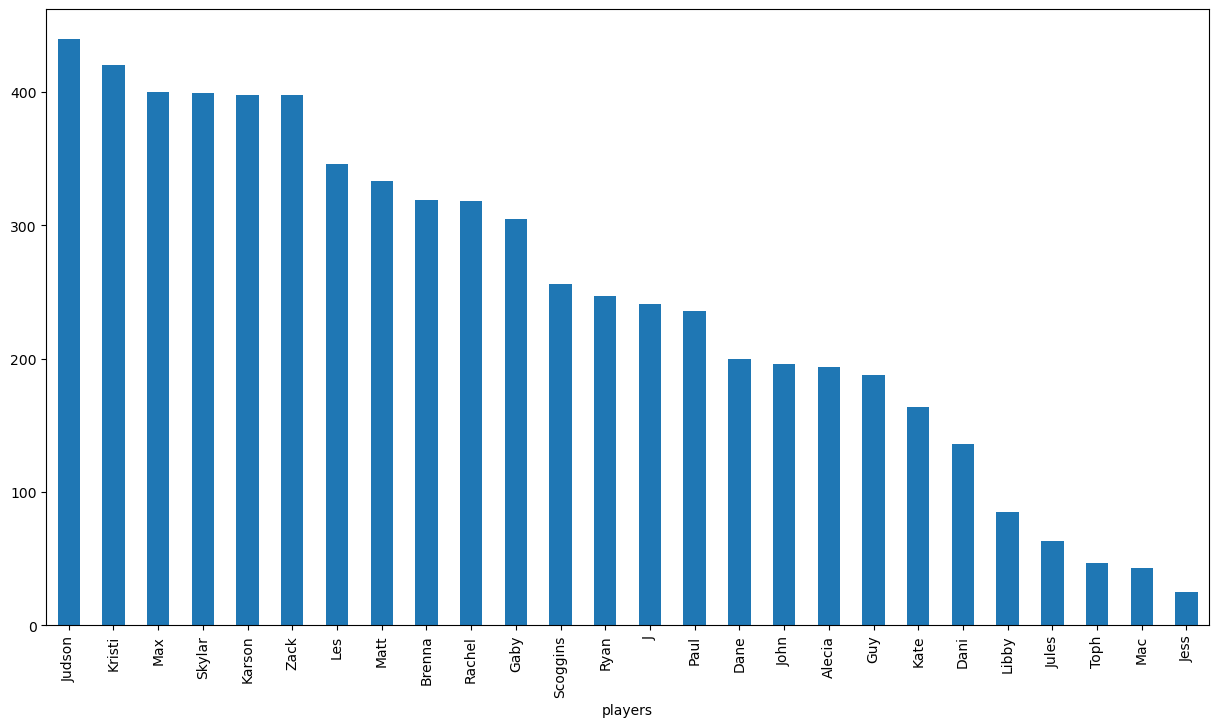

In [122]:
ranking = player_games_df.groupby('players')['score'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15, 8))

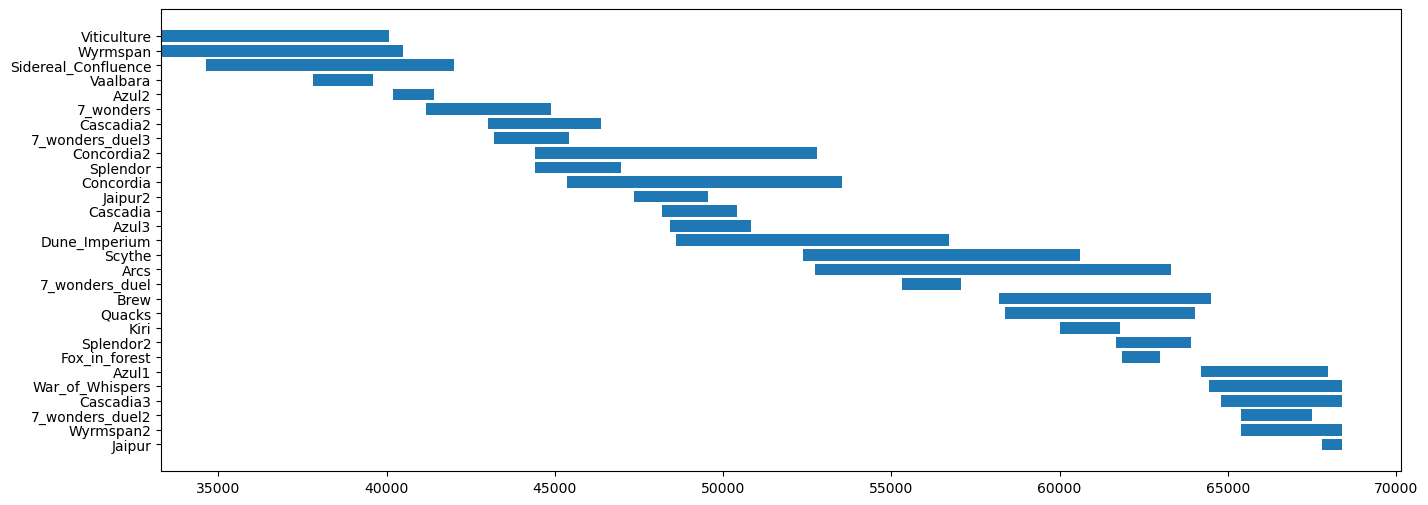

In [123]:
fig, ax = plt.subplots(1, figsize=(16,6))
gantt = games_df.sort_values(by='game_start', ascending=False)
ax.barh(gantt['game_played'], (gantt['game_end']-gantt['game_start']).dt.total_seconds(),left=gantt['game_start'].dt.hour*60*60+gantt['game_start'].dt.minute*60)
plt.show()

# OpenSkill Ranking

In [1]:
from openskill.models import PlackettLuce

model = PlackettLuce()

In [2]:
games_df

NameError: name 'games_df' is not defined

In [94]:
player_rankings = {player:model.rating(name=player) for player in games_df['players'].explode().drop_duplicates().tolist()}

In [95]:
player_rankings

{'Scoggins': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Zack': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Max': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Celeste': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Brenna': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'John': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Hamen': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Skylar': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Preston': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Jesse': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Caitlin': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Paul': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'J': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Les': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Meghann': PlackettLuceRating(mu=25.0, sigma=8.333333333333334),
 'Dane': PlackettLuceRating(mu=25.0, s

In [96]:
for game in games_df['players'].to_list():
    match = [(lambda x: [x])(ranking) for ranking in [player_rankings.get(key) for key in game]]
    results = model.rate(match)
    print(player_rankings)

{'Scoggins': PlackettLuceRating(mu=27.869048680749426, sigma=8.205243377397993), 'Zack': PlackettLuceRating(mu=25.717262170187357, sigma=8.058224222802378), 'Max': PlackettLuceRating(mu=21.413689149063217, sigma=8.058224222802378), 'Celeste': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Brenna': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'John': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Hamen': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Skylar': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Preston': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Jesse': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Caitlin': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Paul': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'J': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Les': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Meghann': PlackettLuceRating(mu=25.0, sigma=8.333333333333334), 'Dane': Pl

In [97]:
[(player, round(rating.mu,2), round(rating.sigma,2)) for player, rating in sorted(player_rankings.items(), key=lambda x:x[1].mu, reverse=True)]

[('Max', 39.85, 6.72),
 ('Rachel', 38.46, 7.51),
 ('Judson', 36.22, 7.36),
 ('Kristi', 35.71, 7.4),
 ('Skylar', 32.96, 6.48),
 ('Karson', 32.33, 6.57),
 ('Toph', 31.62, 7.4),
 ('Zack', 29.61, 6.01),
 ('Ryan', 28.93, 7.84),
 ('Scoggins', 28.12, 7.08),
 ('Dani', 27.92, 8.29),
 ('Celeste', 27.27, 8.0),
 ('Mac', 26.23, 7.93),
 ('Guy', 25.62, 7.67),
 ('Caitlin', 25.24, 7.6),
 ('Libby', 24.44, 8.09),
 ('Dane', 24.08, 7.31),
 ('Hamen', 24.03, 7.84),
 ('Preston', 23.73, 6.9),
 ('Reed', 22.3, 8.06),
 ('Alecia', 22.28, 7.65),
 ('Matt', 21.67, 7.1),
 ('Meghann', 20.96, 8.08),
 ('Jesse', 20.82, 8.06),
 ('John', 20.71, 6.41),
 ('Lindsey', 20.15, 7.62),
 ('Gaby', 19.46, 7.07),
 ('J', 19.3, 7.26),
 ('Les', 19.03, 6.67),
 ('Camilla', 18.85, 7.51),
 ('Jules', 18.22, 7.3),
 ('Paul', 18.16, 6.59),
 ('Kate', 17.66, 7.15),
 ('Jess', 16.59, 7.8),
 ('Brenna', 16.1, 6.59)]

In [101]:
model.predict_draw([[player_rankings['Max']], [player_rankings['Rachel']]])

0.5291764206013845

In [103]:
model.predict_win([[player_rankings['Rachel']], [player_rankings['Max']]])

[0.45282175835583793, 0.5471782416441621]

# Network Visualization and Centrality

In [105]:
import networkx as nx
import matplotlib.pyplot as plt

In [106]:
G = nx.Graph()

In [107]:
G.add_nodes_from(np.unique(player_games_df['players'].values))
G.add_edges_from(set(chain(*[list(combinations(game,2)) for game in [sorted(game) for game in games_df['players'].to_list()]])))

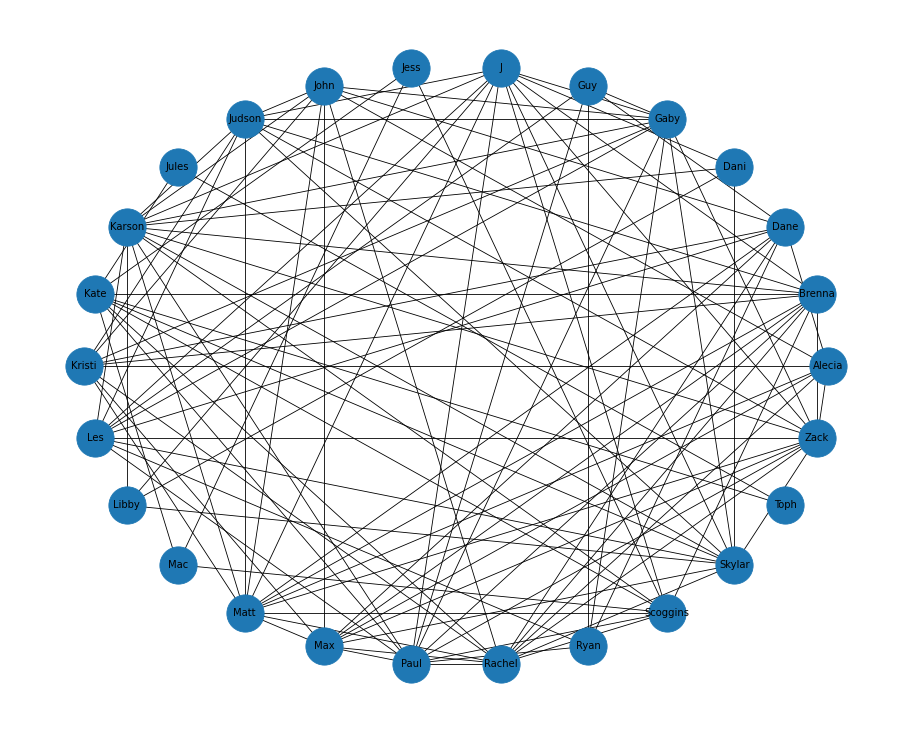

In [108]:
fig = plt.figure(1, figsize=(15,12), dpi=60)
nx.draw_circular(G, with_labels=True, node_size=2000)

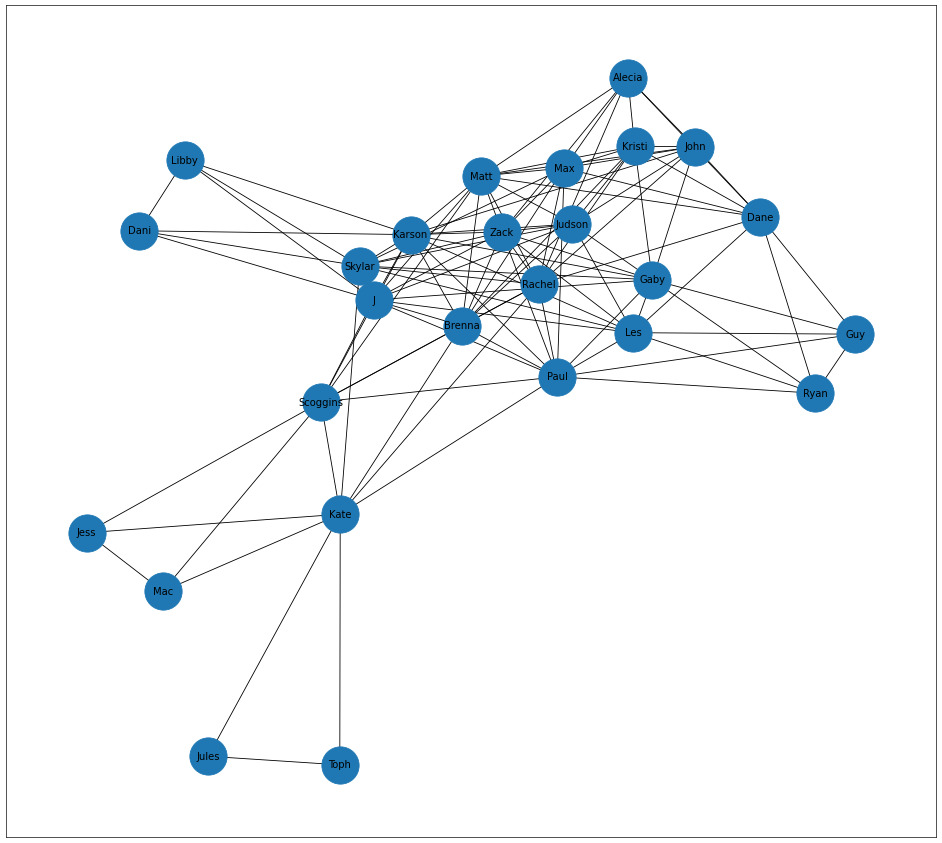

In [109]:
fig = plt.figure(2, figsize=(20,18), dpi=60)
nx.draw_networkx(G, with_labels=True, node_size=2000)

In [113]:
sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)

[('Karson', 0.52),
 ('J', 0.48),
 ('Matt', 0.48),
 ('Paul', 0.48),
 ('Rachel', 0.48),
 ('Zack', 0.48),
 ('Brenna', 0.44),
 ('Gaby', 0.44),
 ('Skylar', 0.44),
 ('Judson', 0.4),
 ('Les', 0.4),
 ('Max', 0.4),
 ('Dane', 0.36),
 ('John', 0.36),
 ('Kate', 0.36),
 ('Kristi', 0.36),
 ('Scoggins', 0.36),
 ('Alecia', 0.28),
 ('Guy', 0.2),
 ('Ryan', 0.2),
 ('Dani', 0.16),
 ('Libby', 0.16),
 ('Jess', 0.12),
 ('Mac', 0.12),
 ('Jules', 0.08),
 ('Toph', 0.08)]

In [114]:
sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)

[('Paul', 0.6578947368421053),
 ('Rachel', 0.6578947368421053),
 ('Brenna', 0.6410256410256411),
 ('Karson', 0.6410256410256411),
 ('Skylar', 0.6410256410256411),
 ('J', 0.625),
 ('Matt', 0.625),
 ('Kate', 0.6097560975609756),
 ('Scoggins', 0.6097560975609756),
 ('Zack', 0.5952380952380952),
 ('Gaby', 0.5813953488372093),
 ('Judson', 0.5681818181818182),
 ('Les', 0.5681818181818182),
 ('Max', 0.5681818181818182),
 ('John', 0.5555555555555556),
 ('Dane', 0.5319148936170213),
 ('Kristi', 0.5319148936170213),
 ('Alecia', 0.5102040816326531),
 ('Guy', 0.49019607843137253),
 ('Ryan', 0.49019607843137253),
 ('Dani', 0.45454545454545453),
 ('Libby', 0.45454545454545453),
 ('Jess', 0.4166666666666667),
 ('Mac', 0.4166666666666667),
 ('Jules', 0.390625),
 ('Toph', 0.390625)]

In [115]:
sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)

[('Kate', 0.20517063492063492),
 ('Paul', 0.10175396825396826),
 ('Skylar', 0.09369413919413921),
 ('Scoggins', 0.09306349206349208),
 ('Rachel', 0.08394536019536021),
 ('Karson', 0.06668711843711844),
 ('J', 0.05086477411477411),
 ('Brenna', 0.04278754578754578),
 ('Matt', 0.038787545787545785),
 ('Gaby', 0.03590750915750916),
 ('Dane', 0.03261111111111111),
 ('Les', 0.02852777777777778),
 ('Zack', 0.023067460317460316),
 ('Max', 0.014945360195360195),
 ('John', 0.012544566544566545),
 ('Judson', 0.0123003663003663),
 ('Kristi', 0.009055555555555556),
 ('Alecia', 0.0016190476190476191),
 ('Guy', 0.0013333333333333335),
 ('Ryan', 0.0013333333333333335),
 ('Dani', 0.0),
 ('Jess', 0.0),
 ('Jules', 0.0),
 ('Libby', 0.0),
 ('Mac', 0.0),
 ('Toph', 0.0)]

In [116]:
sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)

[('Karson', 0.055568600875812175),
 ('Paul', 0.052475170903862355),
 ('Kate', 0.052439877540679775),
 ('J', 0.051875448516760285),
 ('Rachel', 0.05163894630681782),
 ('Matt', 0.050195472664462774),
 ('Zack', 0.04979237295010067),
 ('Skylar', 0.04885757422711938),
 ('Brenna', 0.04754602930212166),
 ('Gaby', 0.04712865550333909),
 ('Scoggins', 0.044431553650274916),
 ('Les', 0.0435246086696339),
 ('Max', 0.04253206304768208),
 ('Judson', 0.04225735406037153),
 ('Dane', 0.03982592285891992),
 ('Kristi', 0.038705997192971915),
 ('John', 0.03866878244090979),
 ('Alecia', 0.031193216568610318),
 ('Guy', 0.02480548597021697),
 ('Ryan', 0.02480548597021697),
 ('Dani', 0.021399704147942407),
 ('Libby', 0.021399704147942407),
 ('Jess', 0.02081737124456423),
 ('Mac', 0.02081737124456423),
 ('Jules', 0.018648614997051158),
 ('Toph', 0.018648614997051158)]

In [117]:
sorted(nx.eigenvector_centrality(G).items(), key=lambda x: x[1], reverse=True)

[('Zack', 0.29010998995716863),
 ('Karson', 0.28138992686919156),
 ('Matt', 0.27418565935806744),
 ('J', 0.26272314847553263),
 ('Brenna', 0.25936256326462104),
 ('Rachel', 0.25798559959446077),
 ('Paul', 0.25256317876836093),
 ('Judson', 0.24535735500897407),
 ('Gaby', 0.23755025252901246),
 ('Skylar', 0.231158660559711),
 ('Max', 0.23039352498680507),
 ('Les', 0.21616397044333222),
 ('John', 0.20603071782217658),
 ('Kristi', 0.20403496550822225),
 ('Scoggins', 0.177594350593535),
 ('Dane', 0.1740192030461727),
 ('Alecia', 0.1630681438248237),
 ('Kate', 0.12694348329164154),
 ('Guy', 0.09740769576128369),
 ('Ryan', 0.09740769576128368),
 ('Dani', 0.08578671442672998),
 ('Libby', 0.08578671442672998),
 ('Jess', 0.0336985646397951),
 ('Mac', 0.0336985646397951),
 ('Jules', 0.014046954007525859),
 ('Toph', 0.014046954007525859)]

# Todo
* Create Player rundown
* Social Butterfly Award (played most players, centrality)
* Game rundown
